<h1>模型验证及优化<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#模型验证及选择" data-toc-modified-id="模型验证及选择-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>模型验证及选择</a></span><ul class="toc-item"><li><span><a href="#整体说明及准备工作" data-toc-modified-id="整体说明及准备工作-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>整体说明及准备工作</a></span></li><li><span><a href="#评价指标及预测方式等" data-toc-modified-id="评价指标及预测方式等-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>评价指标及预测方式等</a></span></li><li><span><a href="#验证方式" data-toc-modified-id="验证方式-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>验证方式</a></span><ul class="toc-item"><li><span><a href="#简单交叉验证" data-toc-modified-id="简单交叉验证-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>简单交叉验证</a></span></li><li><span><a href="#K折交叉验证-K-fold-CV" data-toc-modified-id="K折交叉验证-K-fold-CV-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>K折交叉验证 K-fold CV</a></span></li><li><span><a href="#留P法-LPO-CV" data-toc-modified-id="留P法-LPO-CV-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>留P法 LPO CV</a></span></li><li><span><a href="#StratifiedKFold" data-toc-modified-id="StratifiedKFold-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>StratifiedKFold</a></span></li></ul></li><li><span><a href="#模型比较" data-toc-modified-id="模型比较-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>模型比较</a></span><ul class="toc-item"><li><span><a href="#线下评测分数" data-toc-modified-id="线下评测分数-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>线下评测分数</a></span></li><li><span><a href="#绘制学习曲线进行可视化分析" data-toc-modified-id="绘制学习曲线进行可视化分析-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>绘制学习曲线进行可视化分析</a></span></li></ul></li></ul></li><li><span><a href="#模型超参空间及调参" data-toc-modified-id="模型超参空间及调参-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>模型超参空间及调参</a></span><ul class="toc-item"><li><span><a href="#以随机森林为例介绍基本调用方法" data-toc-modified-id="以随机森林为例介绍基本调用方法-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>以随机森林为例介绍基本调用方法</a></span><ul class="toc-item"><li><span><a href="#穷举网格搜索" data-toc-modified-id="穷举网格搜索-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>穷举网格搜索</a></span></li><li><span><a href="#随机参数优化" data-toc-modified-id="随机参数优化-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>随机参数优化</a></span></li></ul></li><li><span><a href="#F3特征集和LightGBM-网格调参" data-toc-modified-id="F3特征集和LightGBM-网格调参-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>F3特征集和LightGBM 网格调参</a></span></li><li><span><a href="#绘制验证曲线" data-toc-modified-id="绘制验证曲线-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>绘制验证曲线</a></span></li></ul></li></ul></div>

# 模型验证及选择

## 整体说明及准备工作

按照：
评价指标
验证方式
学习曲线
结果分析，模型选择
模型调参
的步骤对模型进行选择，调优

In [4]:
from sklearn import metrics  
import numpy as np  
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
#########部分SKLearn 集成的算法###############
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB 
#########SKLearn 集成的算法###############
import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline
############全局参数#################################
id_col_names=['user_id','coupon_id','date_received']
target_col_name='label'
id_target_cols=['user_id','coupon_id','date_received','label']
myeval='roc_auc'
#cvscore=0
############目录定义#################################
datapath = '../data/' 
featurepath = '../feature/' 
resultpath = '../result/'
tmppath = '../tmp/'
scorepath = '../score/'

In [5]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]

#返回Target列
def get_target_df(df):
    return df[target_col_name]

#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

#按特征名读取训练集
def read_featurefile_train(featurename): 
    df=pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取测试集
def read_featurefile_test(featurename): 
    df=pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

# 将特征归一化
def standize_df(train_data,test_data):
    from sklearn import preprocessing 
    
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])
    
    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])
    
    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns
    
    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns
    
    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler,test_data_scaler

#按特征名读取数据
def read_data(featurename): 
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    #return traindf,testdf  
    return standize_df(traindf,testdf)  

In [6]:
#数据读取
#所有的特征都是上一节生成的
train_f1,test_f1=read_data('f1')
#所有的特征都是上一节生成的
train_f2,test_f2=read_data('sf2')
#所有的特征都是上一节生成的
train_f3,test_f3=read_data('sf3')

## 评价指标及预测方式等

In [7]:
#性能评价函数
#本赛题目标是预测投放的优惠券是否核销。
#针对此任务及一些相关背景知识，使用优惠券核销预测的平均AUC（ROC曲线下面积）作为评价标准。 
#即对每个优惠券coupon_id单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。
# coupon平均auc计算
from sklearn.metrics import roc_auc_score 
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        #测算AUC必须大于1个类别
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)

虽然赛题是按照coupon的AUC来计算。不过因为整体AUC（也就是用roc_auc_score 求出的结果）与Coupon AUC同增同减，所以在进行评估的时候可以直接使用整体AUC。

预测方式，因为要的结果是购买的几率，所以不能直接用Predict因为这样会直接返回0,1,而要用predict_proba，它会返回每个类别的可能行，取其中为1的列即可

## 验证方式

### 简单交叉验证

In [8]:
# 简单交叉验证F1

from sklearn.model_selection import train_test_split # 切分数据
target = get_target_df(train_f1).copy()
traindf=train_f1.copy()
# 切分数据 训练数据80% 验证数据20%
train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred=clf.predict_proba(train_data)[:,1]
test_pred=clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("LogisticRegression train 总体AUC:   ", score_train)
print("LogisticRegression test 总体AUC:   ", score_test)

train_all['pred']=train_pred
test_all['pred']=test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train 总体AUC:    0.6634053234953916
LogisticRegression test 总体AUC:    0.6674416674688228
LogisticRegression train Coupon AUC:    0.5402870051010003
LogisticRegression test Coupon AUC:    0.5410440709758992


In [9]:
# 简单交叉验证 F3

from sklearn.model_selection import train_test_split # 切分数据

target = get_target_df(train_f3).copy()
traindf=train_f3.copy()

# 切分数据 训练数据80% 验证数据20%
train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred=clf.predict_proba(train_data)[:,1]
test_pred=clf.predict_proba(test_data)[:,1]

score_train = roc_auc_score(train_target,train_pred )
score_test = roc_auc_score(test_target, test_pred)
print("LogisticRegression train 总体AUC:   ", score_train)
print("LogisticRegression test 总体AUC:   ", score_test)

train_all['pred']=train_pred
test_all['pred']=test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train 总体AUC:    0.8442307693374849
LogisticRegression test 总体AUC:    0.845122660897918
LogisticRegression train Coupon AUC:    0.7211551245553377
LogisticRegression test Coupon AUC:    0.7441844335038528


### K折交叉验证 K-fold CV

In [31]:
# 5折交叉验证
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = LogisticRegression() 
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred=clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred=clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred']=train_pred
    test_data['pred']=test_pred
    print(k+1, " 折", "LogisticRegression train 总体AUC:   ", score_train)
    print(k+1, " 折", "LogisticRegression test 总体AUC:   ", score_test)  
    print(k+1, " 折", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k+1, " 折", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n')

1  折 LogisticRegression train 总体AUC:    0.837345611697
1  折 LogisticRegression test 总体AUC:    0.8707048174
1  折 LogisticRegression train Coupon AUC:    0.720829003213
1  折 LogisticRegression test Coupon AUC:    0.734005079515 

2  折 LogisticRegression train 总体AUC:    0.837896753907
2  折 LogisticRegression test 总体AUC:    0.869158984347
2  折 LogisticRegression train Coupon AUC:    0.722887544321
2  折 LogisticRegression test Coupon AUC:    0.724054939065 

3  折 LogisticRegression train 总体AUC:    0.849222224915
3  折 LogisticRegression test 总体AUC:    0.825331866749
3  折 LogisticRegression train Coupon AUC:    0.725390841419
3  折 LogisticRegression test Coupon AUC:    0.730013129387 

4  折 LogisticRegression train 总体AUC:    0.850172798385
4  折 LogisticRegression test 总体AUC:    0.822161974238
4  折 LogisticRegression train Coupon AUC:    0.716730536335
4  折 LogisticRegression test Coupon AUC:    0.746817487494 

5  折 LogisticRegression train 总体AUC:    0.84991173704
5  折 LogisticRegression test

### 留P法 LPO CV

In [32]:
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import LeavePOut
lpo = LeavePOut(p=200)
num = 100
for k, (train_index, test_index) in enumerate(lpo.split(train)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = LogisticRegression() 
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred=clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred=clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred']=train_pred
    test_data['pred']=test_pred
    print(k+1, " 折", "LogisticRegression train 总体AUC:   ", score_train)
    print(k+1, " 折", "LogisticRegression test 总体AUC:   ", score_test)  
    print(k+1, " 折", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k+1, " 折", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n')
    if k >= 5:
        break

1  折 LogisticRegression train 总体AUC:    0.844801118615
1  折 LogisticRegression test 总体AUC:    0.896941489362
1  折 LogisticRegression train Coupon AUC:    0.720684812987
1  折 LogisticRegression test Coupon AUC:    0.657894736842 

2  折 LogisticRegression train 总体AUC:    0.844794141396
2  折 LogisticRegression test 总体AUC:    0.896941489362
2  折 LogisticRegression train Coupon AUC:    0.720770461606
2  折 LogisticRegression test Coupon AUC:    0.675 

3  折 LogisticRegression train 总体AUC:    0.844801150159
3  折 LogisticRegression test 总体AUC:    0.896941489362
3  折 LogisticRegression train Coupon AUC:    0.720684804795
3  折 LogisticRegression test Coupon AUC:    0.657894736842 

4  折 LogisticRegression train 总体AUC:    0.844801237847
4  折 LogisticRegression test 总体AUC:    0.896941489362
4  折 LogisticRegression train Coupon AUC:    0.720684793891
4  折 LogisticRegression test Coupon AUC:    0.657894736842 

5  折 LogisticRegression train 总体AUC:    0.844802162966
5  折 LogisticRegression test 总体AUC

### StratifiedKFold
通过比较发现还是StratifiedKFold比较适合本赛题。因为本赛题正负样本分布不均匀。而StratifiedKFold 分层采样交叉切分，确保训练集，测试集中各类别样本的比例与原始数据集中相同。

In [10]:
# 5折交叉验证
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train,target)):
    train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
    clf = LogisticRegression() 
    clf.fit(get_predictors_df(train_data), train_target)
    
    train_pred=clf.predict_proba(get_predictors_df(train_data))[:,1]
    test_pred=clf.predict_proba(get_predictors_df(test_data))[:,1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred']=train_pred
    test_data['pred']=test_pred
    print(k+1, " 折", "LogisticRegression train 总体AUC:   ", score_train)
    print(k+1, " 折", "LogisticRegression test 总体AUC:   ", score_test)  
    print(k+1, " 折", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k+1, " 折", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n') 

1  折 LogisticRegression train 总体AUC:    0.8372053372482697
1  折 LogisticRegression test 总体AUC:    0.8687338139599339
1  折 LogisticRegression train Coupon AUC:    0.7244255662834408
1  折 LogisticRegression test Coupon AUC:    0.730025757319263 

2  折 LogisticRegression train 总体AUC:    0.8379961144637931
2  折 LogisticRegression test 总体AUC:    0.8724991576085558
2  折 LogisticRegression train Coupon AUC:    0.719186178459241
2  折 LogisticRegression test Coupon AUC:    0.7342186628109415 

3  折 LogisticRegression train 总体AUC:    0.8484264661642316
3  折 LogisticRegression test 总体AUC:    0.8297601049649543
3  折 LogisticRegression train Coupon AUC:    0.7225151624402235
3  折 LogisticRegression test Coupon AUC:    0.7307145876564921 

4  折 LogisticRegression train 总体AUC:    0.8501477800991969
4  折 LogisticRegression test 总体AUC:    0.8210263912533682
4  折 LogisticRegression train Coupon AUC:    0.720396025535429
4  折 LogisticRegression test Coupon AUC:    0.7440700245280267 

5  折 LogisticRegres

## 模型比较

### 线下评测分数
选定StratifiedKFold后我们可以直接用上面的方法对不同模型进行比对。也可以sklearn.model_selection.cross_val_score函数。它在cv是整数，而且目标是类别的时候也是用的StratifiedKFold。具体看：
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
不过本赛题因为评测指标是按Coupon的AUC，所以不能用它，要自己计算。

In [11]:
####################使用sklearn的统一代码框架##########################
#提供的函数包括：
#classifier_single(featurename,classifier,cvnum)
#按满减情况分别预测
#classifier_single_sep_fd(featurename,classifier,cvnum): 
####################整合在sklearn的分类算法###############
def get_sklearn_model(model_name,param=None):
    #朴素贝叶斯
    if model_name=='NB':
        model = MultinomialNB(alpha=0.01)
    #逻辑回归
    elif model_name=='LR':
        model = LogisticRegression(penalty='l2') 
    # KNN  
    elif model_name=='KNN':
        model = KNeighborsClassifier()  
    #随机森林
    elif model_name=='RF':
        model = RandomForestClassifier()  
    #决策树
    elif model_name=='DT':
        model = tree.DecisionTreeClassifier()  
    #向量机
    elif model_name=='SVC':
        model = SVC(kernel='rbf')
    #GBDT
    elif model_name=='GBDT':
        model = GradientBoostingClassifier()
    #XGBoost
    elif model_name=='XGB':
        model = XGBClassifier()
    #lightGBM
    elif model_name=='LGB':
        model = LGBMClassifier()
    else:
        print("wrong model name!")
        return
    if param is not None:
        model.set_params(**param)
    return model

#对算法进行分析
def classifier_df_score(train_feat,classifier,cvnum,param=None):  
    clf=get_sklearn_model(classifier,param)
    train = train_feat.copy()
    target = get_target_df(train_feat).copy()
    kf = StratifiedKFold(n_splits=cvnum)
    
    scores=[]
    score_coupons=[]
    for k, (train_index, test_index) in enumerate(kf.split(train,target)):
        train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
        clf.fit(get_predictors_df(train_data), train_target) 
        train_pred=clf.predict_proba(get_predictors_df(train_data))[:,1]
        test_pred=clf.predict_proba(get_predictors_df(test_data))[:,1]
        
        score_test = roc_auc_score(test_target, test_pred)
        test_data['pred']=test_pred
        score_coupon_test=myauc(test_data)
        
        scores.append(score_test)
        score_coupons.append(score_coupon_test)
        
    print (classifier+"总体AUC:",scores)
    print (classifier+"Coupon AUC:",score_coupons)

In [12]:
#f1特征
train=train_f1.copy()
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,label,user_id,coupon_id,date_received
0,0.812785,0.1,1.0,0.500000,0.20,0,1439408,11002,20160528
1,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160613
2,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160516
3,0.761035,0.0,1.0,0.100000,0.05,0,2029232,1532,20160530
4,0.939117,0.0,1.0,0.066667,0.01,0,2029232,12737,20160519


In [13]:
print ('特征f1, 不同模型5折训练Score：')
classifier_df_score(train,'NB',5)
classifier_df_score(train,'LR',5)
classifier_df_score(train,'RF',5)
classifier_df_score(train,'LGB',5)

特征f1, 不同模型5折训练Score：
NB总体AUC: [0.6484186809106656, 0.6538346697838108, 0.6573801264615924, 0.6503909739692905, 0.6633592555110361]
NBCoupon AUC: [0.5363631418076686, 0.5338265093921163, 0.5334927461290747, 0.5415356445668099, 0.5384562409294064]
LR总体AUC: [0.662998106407068, 0.6610222953438731, 0.6640819754240302, 0.6626296651162892, 0.6707402256077268]
LRCoupon AUC: [0.5363729410757857, 0.5338265093921163, 0.5334926446293967, 0.5415356445668099, 0.5385172586508946]
RF总体AUC: [0.6837818154290338, 0.6840488616682929, 0.6845524471463289, 0.6821001263879451, 0.6868554393210143]
RFCoupon AUC: [0.5320362352910335, 0.5288615304152723, 0.521524622079353, 0.5280547805261343, 0.5382860192805202]
LGB总体AUC: [0.6852878649490461, 0.6851764127466513, 0.6854952140724672, 0.6829579737391689, 0.6888458641150075]
LGBCoupon AUC: [0.5332234606335067, 0.5263981314439726, 0.5266188142667052, 0.5323569762717271, 0.5405386626715268]


In [14]:
#f2特征
train=train_f2.copy()
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,user_merchant_any,user_merchant_buy_common,user_merchant_coupon_transfer_rate,user_merchant_coupon_buy_rate,user_merchant_rate,user_merchant_common_buy_rate,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.012346,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.012346,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.012346,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


In [15]:
print ('特征f2, 不同模型5折训练Score：')
classifier_df_score(train,'NB',5)
classifier_df_score(train,'LR',5)
classifier_df_score(train,'RF',5)
classifier_df_score(train,'LGB',5)

特征f2, 不同模型5折训练Score：
NB总体AUC: [0.8220931929754454, 0.8041439476875973, 0.7473969057092373, 0.7364328011348492, 0.7399166479676679]
NBCoupon AUC: [0.6306880228045485, 0.6121314261743251, 0.6074369206205684, 0.6123035068071413, 0.6024926183731578]
LR总体AUC: [0.838045425561811, 0.8334355217191942, 0.783652453548241, 0.773103759281277, 0.7756141925452026]
LRCoupon AUC: [0.6298167791379139, 0.6227174633378124, 0.6094751774429826, 0.6104889106210036, 0.6066915809142149]
RF总体AUC: [0.7936834424246084, 0.7874745254903434, 0.7708781489979948, 0.7779500793819797, 0.7919143047731462]
RFCoupon AUC: [0.5827273579016518, 0.5445530079000613, 0.5304042583008893, 0.5564659344399356, 0.5592552801520129]
LGB总体AUC: [0.8746736157221453, 0.8741332447626633, 0.8476246849601786, 0.8409184961295206, 0.8435429156007278]
LGBCoupon AUC: [0.6357018028553509, 0.5926344244655043, 0.6031016040557363, 0.6113351837785365, 0.6068075517330594]


In [16]:
#f3特征
train=train_f3.copy()
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


In [17]:
print ('特征f3, 不同模型5折训练Score：')
classifier_df_score(train,'NB',5)
classifier_df_score(train,'LR',5)
classifier_df_score(train,'RF',5)
classifier_df_score(train,'LGB',5)

特征f3, 不同模型5折训练Score：
NB总体AUC: [0.8600232871434285, 0.8454000250719758, 0.7975100267142217, 0.7866414257727325, 0.7892483984512402]
NBCoupon AUC: [0.7175196206132957, 0.7179948792774353, 0.7164928734195067, 0.7215488482224762, 0.7188771195885274]
LR总体AUC: [0.8687338139599339, 0.8724991576085558, 0.8297601049649543, 0.8210263912533682, 0.821649452000139]
LRCoupon AUC: [0.730025757319263, 0.7342186628109415, 0.7307145876564921, 0.7440700245280267, 0.7372941943745948]
RF总体AUC: [0.8570804693995167, 0.8603606645981764, 0.845112182697454, 0.8457092679446263, 0.8490906847042663]
RFCoupon AUC: [0.7203001319283459, 0.6991852569646155, 0.7051151722027443, 0.723797478489425, 0.7237838727373146]
LGB总体AUC: [0.902583523893224, 0.9039339269839327, 0.8864817400224342, 0.8810169231038664, 0.8829524946604708]
LGBCoupon AUC: [0.7460752458491179, 0.7438641556642815, 0.7494649031016666, 0.7633777325894878, 0.7641227179819879]


通过对比训练集上不同算法的运算结果可以发现，F1特征集因为特征比较少，有严重的欠拟合，所以所有算法的分数都比较低。
F2特征集通过滑窗增加统计特征，它的分数比f1有了飞跃性的提高，其实在现实的业务场景F2+LR已经是一个很常用的解决方案了。之所以在实际作业中更倾向逻辑回归而不是类似LightGBM的算法，是为了减少计算量。当然如果计算资源不是问题的话，LightGBM也是一个好选择

### 绘制学习曲线进行可视化分析

我们还可以通过绘制学习曲线，对训练的过程进行比较深入的了解。

In [18]:

#画学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    plt.show()
    return plt

#画算法的学习曲线,为加快画图速度，最多选20%数据
def plot_curve_single(traindf,classifier,cvnum,train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]): 
    X=get_predictors_df(traindf)
    y=get_target_df(traindf)
    title = "learning curve of "+classifier+", cv:"+str(cvnum)
    estimator = get_sklearn_model(classifier)    #建模
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)

**F1特征集**

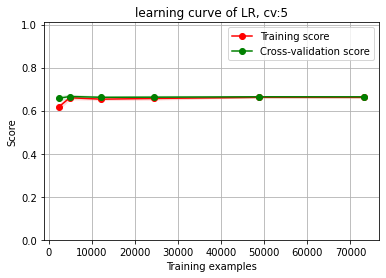

In [19]:
plot_curve_single(train_f1,'LR',5,[0.01,0.02,0.05,0.1,0.2,0.3])

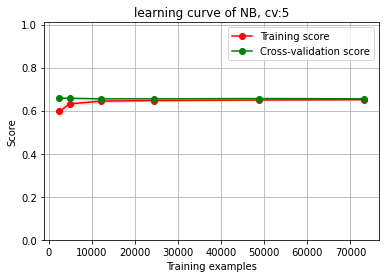

In [20]:
plot_curve_single(train_f1,'NB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

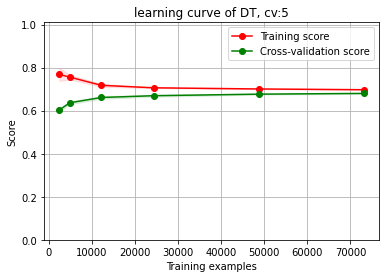

In [21]:
plot_curve_single(train_f1,'DT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

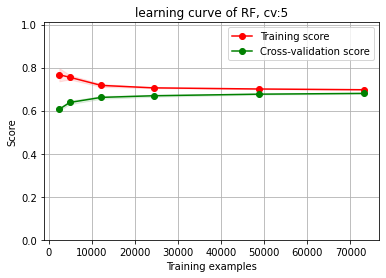

In [22]:
plot_curve_single(train_f1,'RF',5,[0.01,0.02,0.05,0.1,0.2,0.3])

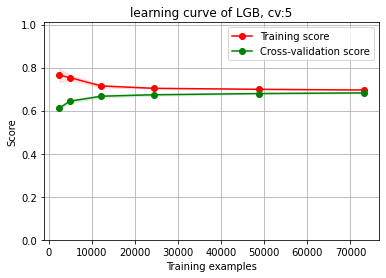

In [23]:
plot_curve_single(train_f1,'LGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

**F2特征集**

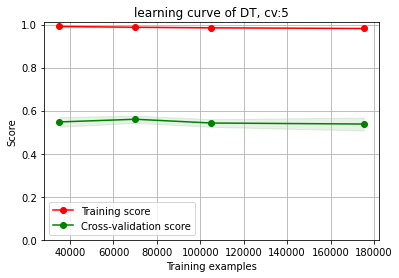

In [24]:
plot_curve_single(train_f2,'DT',5,[0.1,0.2,0.3,0.5])

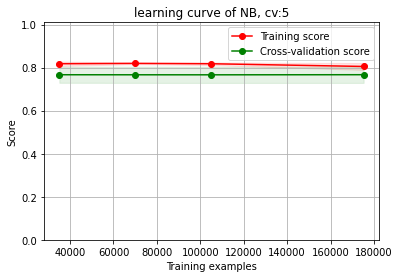

In [25]:
plot_curve_single(train_f2,'NB',5,[0.1,0.2,0.3,0.5])

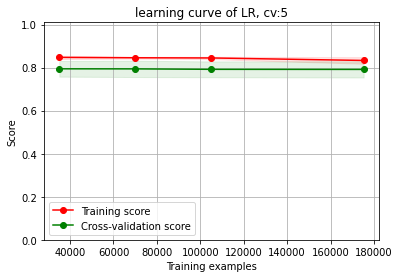

In [26]:
plot_curve_single(train_f2,'LR',5,[0.1,0.2,0.3,0.5])

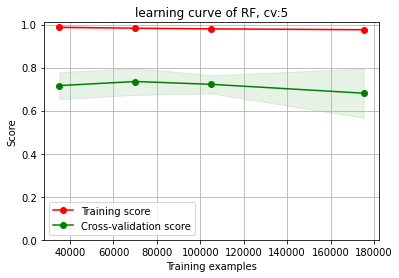

In [27]:
plot_curve_single(train_f2,'RF',5,[0.1,0.2,0.3,0.5])

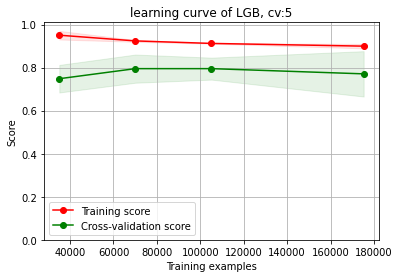

In [28]:
plot_curve_single(train_f2,'LGB',5,[0.1,0.2,0.3,0.5])

**F3特征集**

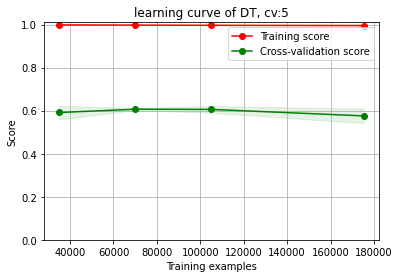

In [30]:
plot_curve_single(train_f3,'DT',5,[0.1,0.2,0.3,0.5])

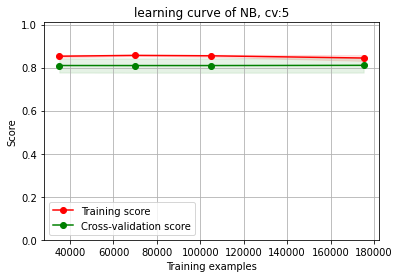

In [31]:
plot_curve_single(train_f3,'NB',5,[0.1,0.2,0.3,0.5])

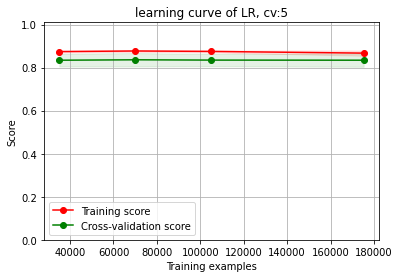

In [32]:
plot_curve_single(train_f3,'LR',5,[0.1,0.2,0.3,0.5])

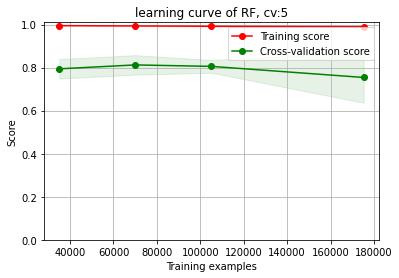

In [33]:
plot_curve_single(train_f3,'RF',5,[0.1,0.2,0.3,0.5])

In [ ]:
plot_curve_single(train_f3,'LGB',5,[0.1,0.2,0.3,0.5])

可以发现在特征集f1上，评测分普遍比较低，是欠拟合。
在特征集f3上决策树和随机森林都表现出过拟合。LGB表现比较好。

# 模型超参空间及调参

In [ ]:
#f3
train = get_predictors_df(train_f3)
target = get_target_df(train_f3)
train.head()

## 以随机森林为例介绍基本调用方法
### 穷举网格搜索

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # 切分数据
# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

model = RandomForestClassifier()
parameters = {
              'n_estimators':[20, 50, 100],
              'max_depth':[1, 2, 3]
        }

clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict(test_data))

print("RandomForestClassifier GridSearchCV test AUC:   ", score_test)
print("最优参数:")
print(clf.best_params_)
sorted(clf.cv_results_.keys())

运行起来我们可以发现网格搜索很耗时间，每次训练及预测的次数是按照参数的个数指数增长的。所以一次不要搜索太多的参数，一般1，2个就可以了。

### 随机参数优化

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # 切分数据
# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

model = RandomForestClassifier()
parameters = {
              'n_estimators':[10,20, 30,50],
              'max_depth':[1, 2, 3]
        }

clf = RandomizedSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict(test_data))

print("RandomForestClassifier RandomizedSearchCV test AUC:   ", score_test)
print("最优参数:")
print(clf.best_params_)
sorted(clf.cv_results_.keys())

## F3特征集和LightGBM 网格调参

LightGBM 调参次序：  
第一步：学习率和迭代次数  
第二步：确定max_depth和num_leaves  
第三步：确定min_data_in_leaf和max_bin in  
第四步：确定feature_fraction、bagging_fraction、bagging_freq  
第五步：确定lambda_l1和lambda_l2  
第六步：确定 min_split_gain   
第七步：降低学习率，增加迭代次数，验证模型  

In [ ]:
#f3特征
traindf=train_f3.copy()

#按日期分割，为了加快速度，只用了一般数据进行网格调参，正式的时候应该全用
train=traindf[traindf.date_received<20160515]
test=traindf[traindf.date_received>=20160515]

train_data = get_predictors_df(train).copy()
train_target = get_target_df(train).copy()
test_data = get_predictors_df(test).copy()
test_target = get_target_df(test).copy()

traindf.head()

In [ ]:
#第一步：学习率和迭代次数
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
# 切分数据 训练数据80% 验证数据20%
# 为了加快速度CV选的3，其实一般用5
# 因为每训练一次耗时很多，所以每个参数的选项不多，间隔比较大，正式的时候应该是比较多，间隔比较细的
# 本次只是演示，所以如果最好参数位于区间的边缘也就直接用了，其实如果最好参数在边缘，需要重新再搜索。


model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',
                       learning_rate=0.1, max_depth=5, bagging_fraction = 0.8,feature_fraction = 0.8)
parameters = {'n_estimators':[100,150,175,200,225,250]}

clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:,1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

In [ ]:
#第二步：确定max_depth和num_leaves
#n_estimators=200
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,
                        learning_rate=0.1, bagging_fraction = 0.8,feature_fraction = 0.8)
parameters={'max_depth': range(4,8,1), 'num_leaves':range(10, 150, 10)}
clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:,1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

根据结果取 max_depth=6, num_leaves=40 也都这么做。

In [ ]:
#第三步：确定min_data_in_leaf和max_bin in
#已经确认内容：
#n_estimators=200
#{'max_depth': 6, 'num_leaves': 40}
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        learning_rate=0.1, bagging_fraction = 0.8,feature_fraction = 0.8)

parameters={'max_bin': range(100,500,50),'min_data_in_leaf':range(100,150,10)}
#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:,1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

In [ ]:
#第四步：确定feature_fraction、bagging_fraction、bagging_freq 
#已经确认内容：
#n_estimators=200
#{'max_depth': 6, 'num_leaves': 40}
#{'max_bin': 400, 'min_data_in_leaf': 120}
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.1, bagging_fraction = 0.8,feature_fraction = 0.8)

parameters={  'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_freq': range(0,10,2)
            }

#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:,1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

In [ ]:
#第五步：确定lambda_l1和lambda_l2
#已经确认内容：
#n_estimators=200
#{'max_depth': 6, 'num_leaves': 40}
#{'max_bin': 400, 'min_data_in_leaf': 120}
#{'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.6}
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.1, 
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)

parameters={'lambda_l1': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
              'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
}

#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:,1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

In [ ]:
#第六步：确定 min_split_gain
#已经确认内容：
#n_estimators=200
#{'max_depth': 6, 'num_leaves': 40}
#{'max_bin': 400, 'min_data_in_leaf': 120}
#{'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.6}
#{'lambda_l1': 1e-05, 'lambda_l2': 1e-05}
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.1, 
                       lambda_l1=1e-05,lambda_l2=1e-05,
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)

parameters={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:,1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

In [ ]:
# 第七步：降低学习率，增加迭代次数，验证模型
#已经确认内容：
#n_estimators=200
#{'max_depth': 6, 'num_leaves': 40}
#{'max_bin': 400, 'min_data_in_leaf': 120}
#{'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.6}
#{'lambda_l1': 1e-05, 'lambda_l2': 1e-05}
#{'min_split_gain': 0.0}
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.1, 
                       lambda_l1=1e-05,lambda_l2=1e-05,min_split_gain=0.0,
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)


model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:,1])

print("LightGBM learning rate 0.1 AUC Score:   ", score_test)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.05, 
                       lambda_l1=1e-05,lambda_l2=1e-05,min_split_gain=0.0,
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)


model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:,1])

print("LightGBM learning rate 0.05 AUC Score:   ", score_test)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.01, 
                       lambda_l1=1e-05,lambda_l2=1e-05,min_split_gain=0.0,
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)


model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:,1])

print("LightGBM learning rate 0.01 AUC Score:   ", score_test)

model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,
                        max_bin=400,min_data_in_leaf=120,
                        learning_rate=0.005, 
                       lambda_l1=1e-05,lambda_l2=1e-05,min_split_gain=0.0,
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)


model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:,1])

print("LightGBM learning rate 0.005 AUC Score:   ", score_test)

In [ ]:
model = LGBMClassifier()


model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:,1])

print("默认参数 AUC Score:   ", score_test)

最优参数
model = LGBMClassifier(boosting_type='gbdt',objective='binary',metrics='auc',n_estimators=200,max_depth=6,num_leaves=40,  
                        max_bin=400,min_data_in_leaf=120,  
                        learning_rate=0.05,   
                       lambda_l1=1e-05,lambda_l2=1e-05,min_split_gain=0.0,  
                        bagging_freq=4, bagging_fraction = 0.9,feature_fraction = 0.6)  


In [ ]:
#f3特征
train=train_f3.copy()
train.head()
print('默认参数')
classifier_df_score(train,'LGB',5)
params={'boosting_type':'gbdt',
	    'objective': 'binary',
	    'eval_metric':'auc',
	    'n_estimators':200,
	    'max_depth':5,
	    'num_leaves':40,
	    'max_bin':400,
	    'min_data_in_leaf':120,
	    'learning_rate':0.1,
	    'lambda_l1': 1e-05,
	    'lambda_l2':1e-05,
	    'min_split_gain':0.0,
	    'bagging_freq':4,
	    'bagging_fraction': 0.9,
	    'feature_fraction':0.6,
	    'seed':1024,
	    'n_thread':12
	    }
print('调参后')
classifier_df_score(train,'LGB',5,params)

对比发现调参后的结果比默认参数有所提高，不过不是高很多，比不上特征对结果的影响。而且因为调参只能再测试集上作，有的时候调参造成过拟，调参后线上成绩可能反而会下降。所以调参一般都是在比赛后期再做，前期主要是特征和模型的选择。

## 绘制验证曲线

可以通过绘制验证曲线，可视化的了解调参的过程。

In [ ]:
#对进行网格调参
def grid_plot(train_feat,classifier,cvnum,param_range,param_name,param=None):
    from sklearn.model_selection import validation_curve
    train_scores, test_scores = validation_curve(
        get_sklearn_model(classifier,param), get_predictors_df(train_feat), get_target_df(train_feat), param_name=param_name, param_range=param_range,
        cv=cvnum, scoring='roc_auc', n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title("Validation Curve with "+param_name)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

In [ ]:
#对逻辑回归的max_iter情况进行查看
train_feat=train_f3.copy()
#grid_plot(train_feat,classifier,3,[10,20,40,80,200,400,800],'n_estimators',param=params)
grid_plot(train_feat,'LR',3,[1,2,5,10,20,40,50],'max_iter',param=None)

In [ ]:
params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'sub_feature': 0.6,
    'num_leaves': 50,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8
}
train_feat=train_f3.copy()
#grid_plot(train_feat,classifier,3,[10,20,40,80,200,400,800],'n_estimators',param=params)
grid_plot(train_feat,'LGB',3,[10,20,40],'n_estimators',param=params)

In [ ]:
params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 10
}
train_feat=train_f3.copy()
#grid_plot(train_feat,classifier,3,[10,20,40,80,200,400,800],'n_estimators',param=params)
grid_plot(train_feat,'LGB',3,[0.1,0.2,0.5,0.7,0.8],'colsample_bytree',param=params)